1단계: 이미지 처리를 위해 opencv 와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어옵니다.

In [38]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


2단계: matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용합니다.

그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용합니다. 그래서 원본 사진에서 붉은색-> 푸른색, 푸른색-> 붉은색으로 출력됩니다. 

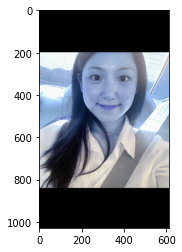

In [129]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

그래서, opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 아래와 같은 색깔 보정처리를 해주게 됩니다.

 img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
 
 plt.imshow(img_rgb)
 
 plt.show()

### 얼굴 검출 face detection

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾습니다.

HOG는 이미지에서 색상의 변화량을 나타낸 것입니다. 딥러닝이 나오기 이전에 다양하게 사용되던 방식입니다.

이미지로부터 물체의 특징을 잘 잡아냅니다.

3단계: detector_hog를 이용해서 얼굴의 bounding box를 추출합니다.


In [126]:
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


4단계: dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

In [127]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


5단계: 찾은 얼굴을 화면에 출력해보겠습니다.

rectangles[[(200, 260) (468, 528)]]


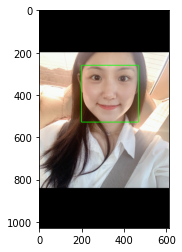

In [128]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()



이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다.

face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

### Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측(지금 예제에서 사용)

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

6단계: 저장한 landmark 모델을 불러옵니다.

In [113]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


7단계: points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 
조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 

(list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 
이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.)

In [114]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


8단계: 랜드마크를 영상에 출력해 보겠습니다.

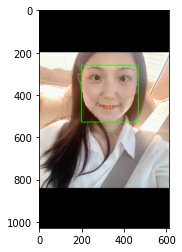

In [115]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

좌표를 확인해 봅니다. 제 얼굴 이미지에서는 코의 중심점이 (325, 530)으로 나옵니다.

In [130]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[8]) 
    x = landmark[8][0]
    y = landmark[8][1] 
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(325, 530)
(x,y) : (325,530)
(w,h) : (269,269)


9단계: 준비해 둔 스티커 이미지를 읽어서 적용해 보겠습니다. 왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize 합니다.

In [131]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(269, 269, 3)


원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

In [132]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (191,261)


In [133]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


이제 원본 이미지에 스티커를 적용합니다.

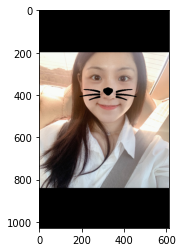

In [134]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

느낀점: 

조원들과 은서님 덕분에 어려울 수 있는 부분들에 대해 공부할 수 있었다.

오늘 새로 알게된 몇 가지
1. CV2에서는 이미지의 왼쪽 윗부분이 (0,0)이다.
2. 